# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

#### Exploración y Curación de Datos - 2024

---

## Trabajo práctico entregable - Parte 2

### Integrantes

- Fernando Camino
- Emanuel Nicolás Herrador
- Juana Rapoport
- Sebastián Stutz
- Juan Ignacio Szurlewicz

In [19]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings as wrn

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.experimental import enable_iterative_imputer # IterativeImputer requires this
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

# Set the style of the visualization
sns.set_context('talk')

# Set seed for reproducibility
np.random.seed(0)

### Lectura del dataset

In [2]:
# Load the data
melb_url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv'
melb_df_orig = pd.read_csv(melb_url)

# Check if the data was loaded correctly
melb_df_orig.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


Como debemos trabajar con el dataset que se obtiene luego de la exploración y limpieza de *outliers* del primer entregable, vamos a realizar las mismas operaciones para tenerlo listo:

In [3]:
# Copy the data to avoid modifying the original information
melb_df = melb_df_orig.copy()

# Select the columns to use
interesting_columns = ['Price', 'Bedroom2', 'Type', 'Rooms', 'Car', 'Landsize', 'Regionname', 'BuildingArea', 'YearBuilt']
melb_df = melb_df[interesting_columns]

# Clean the outliers
q_info = { 'Price': 0.98, 'Bedroom2': 0.99, 'Car': 0.99, 'Landsize': 0.99 }
for col, q in q_info.items():
    max_value = melb_df[col].quantile(q)
    melb_df = melb_df[melb_df[col] < max_value]

Y ahora vemos cómo nos quedan todas las distribuciones de nuestros datos luego de esta limpieza. Para ello, vamos a hacer uso de las funciones de box_plot_simple, kde_plot e hist_plot que definimos en el entregable anterior.

In [4]:
def box_plot_simple(data, x, title, xlabel, ax, tick_diff = None):
    g = sns.boxplot(x=x, data=data, ax=ax, color='orange', fliersize = 5, \
        showmeans = True, meanprops = {'marker': '.', 'markerfacecolor': 'black', 'markeredgecolor': 'black'})
    g.set_title(title)
    g.set_xlabel(xlabel)

    if tick_diff:
        g.set_xticks(np.arange(0, data[x].max() + tick_diff, tick_diff))
        x_labels = ['{:,.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
        g.set_xticklabels(x_labels)

    return g

def kde_plot(data, x, title, xlabel, ax, tick_diff = None):
    g = sns.kdeplot(data[x], ax=ax, color='orange', fill=True)
    g.set_title(title)
    g.set_xlabel(xlabel)
    g.set_ylabel('Density')

    if tick_diff:
        g.set_xticks(np.arange(0, data[x].max() + tick_diff, tick_diff))
        x_labels = ['{:,.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
        g.set_xticklabels(x_labels)

    return g

def hist_plot(data, x, title, xlabel, ax, kde=False):
    g = sns.histplot(data[x], ax=ax, color='orange', kde=kde, bins=20)
    g.set_title(title)
    g.set_xlabel(xlabel)
    g.set_ylabel('Frecuency')

    return g

Ahora, si vemos los gráficos, podemos observar la información con la que disponemos para trabajar.

    Plotting Price in (0, 0)...
    Plotting Price in (0, 1)...
    Plotting Bedroom2 in (0, 2)...
    Plotting Type in (1, 0)...
    Plotting Rooms in (1, 1)...
    Plotting Car in (1, 2)...
    Plotting Landsize in (2, 0)...
    Plotting Landsize in (2, 1)...
    Plotting Regionname in (2, 2)...
    Plotting BuildingArea in (3, 0)...
    Plotting BuildingArea in (3, 1)...
    Plotting YearBuilt in (3, 2)...


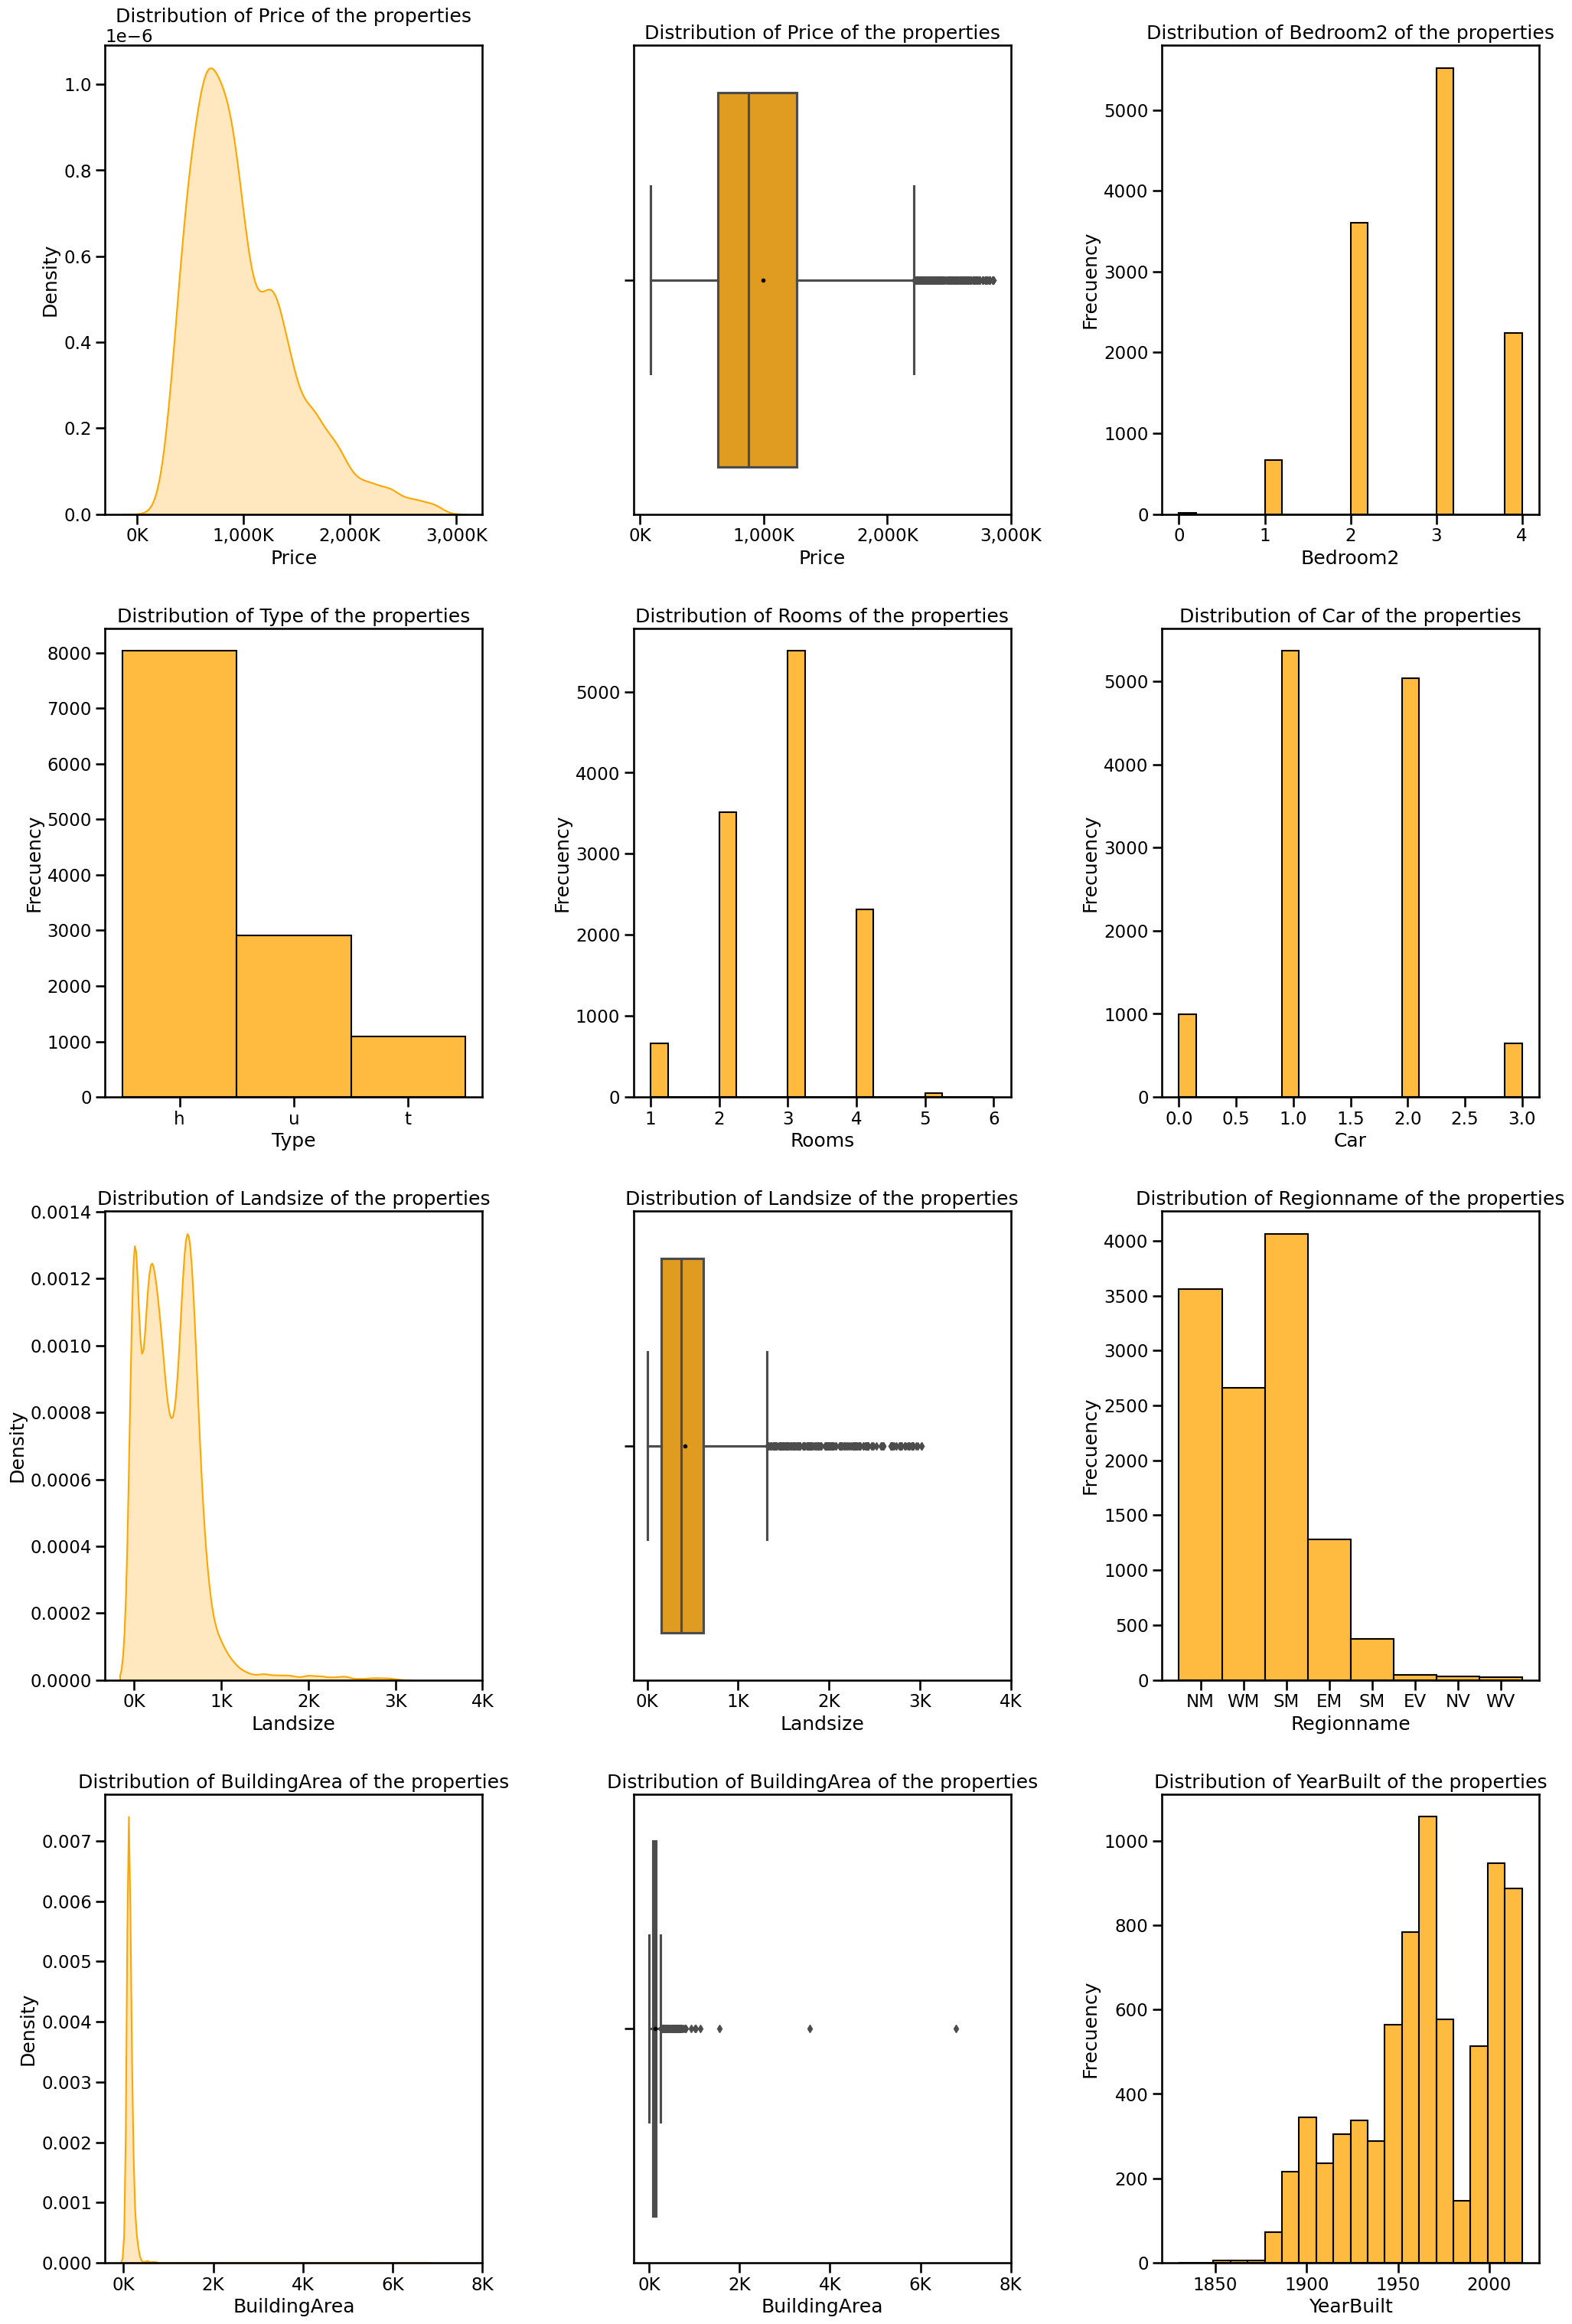

In [5]:
# Don't show FutureWarnings and UserWarnings
wrn.filterwarnings(action='ignore', category=FutureWarning)
wrn.filterwarnings(action='ignore', category=UserWarning)

# GRAPH: All the relevant data distributions
graph_info = {
    'Price': [[kde_plot, box_plot_simple], 1_000_000, False],
    'Bedroom2': [[hist_plot], False, False],
    'Type': [[hist_plot], False, False],
    'Rooms': [[hist_plot], False, False],
    'Car': [[hist_plot], False, False],
    'Landsize': [[kde_plot, box_plot_simple], 1_000, False],
    'Regionname': [[hist_plot], False, True],
    'BuildingArea': [[kde_plot, box_plot_simple], 2_000, False],
    'YearBuilt': [[hist_plot], False, False]
}

fig, axs = plt.subplots(4, 3, figsize=(20, 30))
fig.tight_layout(h_pad=4, w_pad=5)

i = 0
for col, info in graph_info.items():
    for plot in info[0]:
        nrow, ncol = divmod(i, 3)
        print(f'    Plotting {col} in ({nrow}, {ncol})...')

        title = f'Distribution of {col} of the properties'
        g = plot(melb_df, col, title, col, axs[nrow, ncol], info[1])
        if info[2]:
            # Compact the labels with initials
            x_labels = [x.get_text().split(',')[0] for x in g.get_xticklabels()]
            x_labels = [x.split(' ')[0][0] + x.split(' ')[1][0] for x in x_labels]
            g.set_xticklabels(x_labels)
        i += 1

plt.show()


Gracias a ello, podemos notar que es necesario limpiar también los outliers de `BuildingArea` dado que se observan valores muy extremos en la distribución. Consideramos el $98\%$ de los datos como límite superior para eliminarlos y para mejorar la performance de las posteriores combinaciones de *scaling* e *imputation* que hagamos.

Así mismo, si observamos los valores con `BuildingArea` menores a $10$, vemos que no tienen sentido dadas las respuestas en cuanto a tipo de propiedad (la gran mayoría *casas*), cantidad de cocheras y cantidad de habitaciones + dormitorios. Por lo tanto, decidimos eliminarlos.
Esto lo podemos ver a continuación:

In [6]:
melb_df[melb_df['BuildingArea'] <= 10].sample(5, random_state=8)

,Price,Bedroom2,Type,Rooms,Car,Landsize,Regionname,BuildingArea,YearBuilt
3000,330000.0,2.0,h,2,1.0,249.0,Northern Metropolitan,2.0,1970.0
1138,1037000.0,2.0,t,2,2.0,125.0,Southern Metropolitan,2.0,2009.0
7050,655000.0,3.0,h,3,2.0,175.0,Eastern Metropolitan,3.0,NaN
13434,2690000.0,4.0,h,4,2.0,647.0,Southern Metropolitan,0.0,1910.0
4884,751000.0,3.0,h,3,0.0,148.0,Northern Metropolitan,3.0,1950.0


Por ello, realizamos la siguiente limpieza:

<Axes: title={'center': 'Distribution of BuildingArea of the properties'}, xlabel='BuildingArea'>

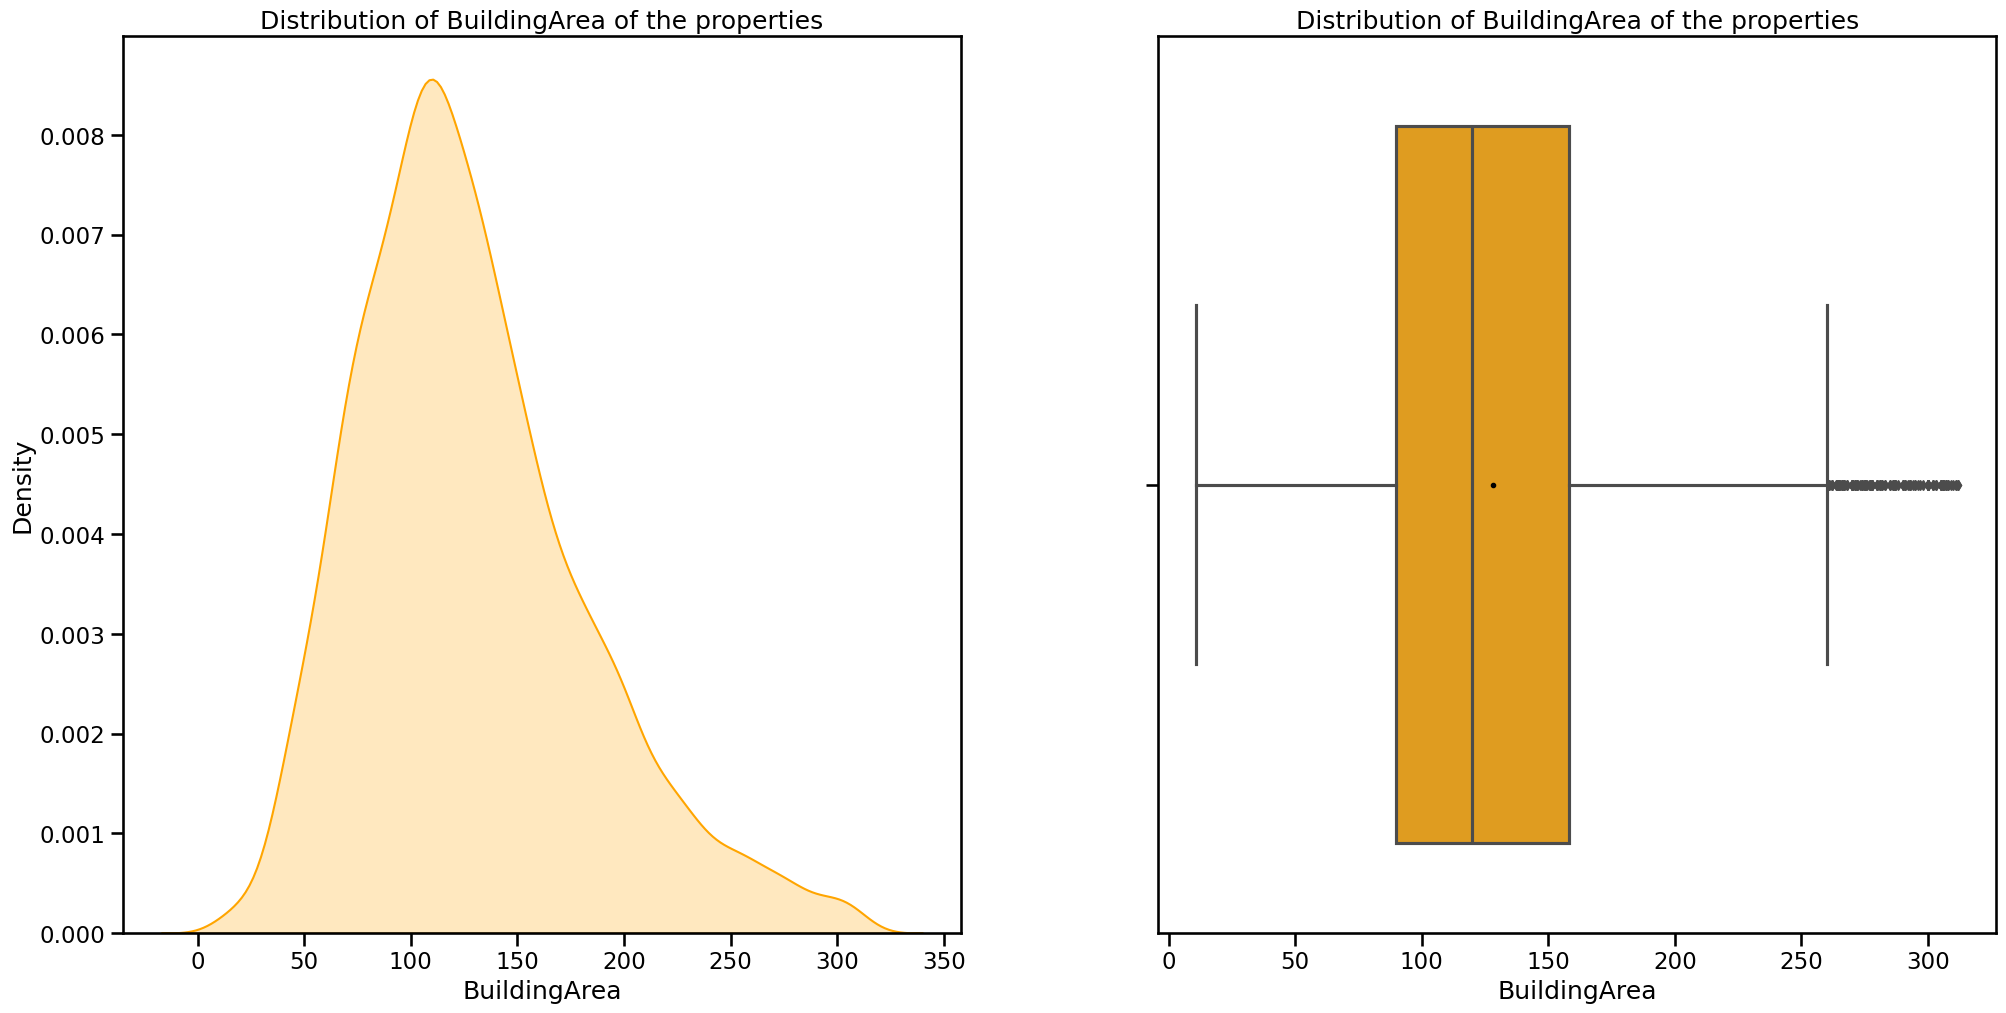

In [7]:
# Clean the outliers
ba_98 = melb_df['BuildingArea'].quantile(0.98)
melb_df = melb_df[((melb_df['BuildingArea'] < ba_98) & (melb_df['BuildingArea'] > 10)) | (melb_df['BuildingArea'].isna())]

# Graph KDE + Boxplot for BuildingArea
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout(h_pad=4, w_pad=5)

kde_plot(melb_df, 'BuildingArea', 'Distribution of BuildingArea of the properties', 'BuildingArea', ax[0])
box_plot_simple(melb_df, 'BuildingArea', 'Distribution of BuildingArea of the properties', 'BuildingArea', ax[1])

Ahora, ya teniendo el *dataset* listo, hagamos un reset de los índices para poder realizar bien el merge luego. Hecho esto, podemos continuar con el segundo entregable.

In [8]:
# Index reset
melb_df.reset_index(drop=True, inplace=True)

### Ejercicio 1: Encoding

#### Consigna

1. Seleccionar todas las filas y columnas del conjunto de datos, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas.
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.

#### Resolución

Respecto a este ejercicio, particularmente sobre el punto (2) de codificación *One-hot* para variables numéricas, consideramos que no es necesario realizarlo dado que, o bien son muchísimos valores (para `Price` por ejemplo), o bien no cobra sentido realizarlo (para `Car` o `Rooms`, por ejemplo), dado que no son variables categóricas y ya tienen un sentido numérico y de orden entre ellos.

Por este mismo motivo, se considerará la aplicación del pre-procesado *One-Hot* únicamente para `Type` y `Regionname`.

In [9]:
# CATEGORICAL ENCODING
print('CATEGORICAL ENCODING CASE\n')

cat_cols = ['Type', 'Regionname']

# Apply one hot encoding
OneHot = OneHotEncoder(handle_unknown='ignore', sparse_output=False, feature_name_combiner=lambda f, c: f + '=' + c)
nw_cat_cols = OneHot.fit_transform(melb_df[cat_cols])

# Get the new columns names
nw_cat_names = OneHot.get_feature_names_out(cat_cols)

# Print encoding information
print(f'Original columns: {cat_cols}\n')
print(f'New columns: {nw_cat_names}\n')
print(f'Shape of the new columns: {nw_cat_cols.shape}\n')

CATEGORICAL ENCODING CASE

Original columns: ['Type', 'Regionname']

New columns: ['Type=h' 'Type=t' 'Type=u' 'Regionname=Eastern Metropolitan'
 'Regionname=Eastern Victoria' 'Regionname=Northern Metropolitan'
 'Regionname=Northern Victoria' 'Regionname=South-Eastern Metropolitan'
 'Regionname=Southern Metropolitan' 'Regionname=Western Metropolitan'
 'Regionname=Western Victoria']

Shape of the new columns: (11848, 11)



Ahora, solo queda agregar los datos numéricos a la matriz de *features* codificadas para continuar con el ejercicio.

In [10]:
# FINAL DATA ENCODED

num_cols = ['Price', 'Bedroom2', 'Rooms', 'Car', 'Landsize']

# Add the numerical columns to the new data
nw_cols = np.hstack([melb_df[num_cols].values, nw_cat_cols])
nw_names = num_cols + nw_cat_names.tolist()

# Print the final data information
print(f'Final columns: {nw_names}\n')
print(f'Shape of the final data: {nw_cols.shape}\n')
print(f'First 5 rows of the final data:\n{[nw_cols[:5]]}\n')

Final columns: ['Price', 'Bedroom2', 'Rooms', 'Car', 'Landsize', 'Type=h', 'Type=t', 'Type=u', 'Regionname=Eastern Metropolitan', 'Regionname=Eastern Victoria', 'Regionname=Northern Metropolitan', 'Regionname=Northern Victoria', 'Regionname=South-Eastern Metropolitan', 'Regionname=Southern Metropolitan', 'Regionname=Western Metropolitan', 'Regionname=Western Victoria']

Shape of the final data: (11848, 16)

First 5 rows of the final data:
[array([[1.480e+06, 2.000e+00, 2.000e+00, 1.000e+00, 2.020e+02, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.035e+06, 2.000e+00, 2.000e+00, 0.000e+00, 1.560e+02, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.465e+06, 3.000e+00, 3.000e+00, 0.000e+00, 1.340e+02, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
      

Por lo que obtenemos el siguiente DataFrame:

In [11]:
# Get the final DataFrame
melb_df_enc = pd.DataFrame(nw_cols, columns=nw_names)

# Show the first 5 rows of the original vs. encoded DataFrame
display(melb_df.sample(5, random_state=0))
display(melb_df_enc.sample(5, random_state=0))

,Price,Bedroom2,Type,Rooms,Car,Landsize,Regionname,BuildingArea,YearBuilt
7811,1116000.0,3.0,h,3,2.0,610.0,Southern Metropolitan,NaN,NaN
1569,1012000.0,2.0,h,2,1.0,0.0,Southern Metropolitan,NaN,NaN
4087,1350000.0,4.0,h,4,2.0,646.0,Northern Metropolitan,287.0,1995.0
5252,1080000.0,3.0,h,3,2.0,211.0,Western Metropolitan,46.0,1980.0
2804,485000.0,2.0,u,1,1.0,0.0,Southern Metropolitan,NaN,NaN


,Price,Bedroom2,Rooms,Car,Landsize,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Eastern Victoria,Regionname=Northern Metropolitan,Regionname=Northern Victoria,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Western Metropolitan,Regionname=Western Victoria
7811,1116000.0,3.0,3.0,2.0,610.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1569,1012000.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4087,1350000.0,4.0,4.0,2.0,646.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5252,1080000.0,3.0,3.0,2.0,211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2804,485000.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Ejercicio 2: Imputación por KNN

#### Consigna

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

#### Resolución

Lo primero que hacemos es agregar las columnas `YearBuilt` y `BuildingArea` al DataFrame de *features* codificadas.

In [12]:
# Create new DataFrame
melb_df_knn = melb_df_enc.copy()

# Add new columns from the original DataFrame
add_cols = ['YearBuilt', 'BuildingArea']
melb_df_knn = pd.concat([melb_df[add_cols], melb_df_knn], axis=1)

# Show random 5 rows of the original vs. encoded DataFrame
display(melb_df.sample(5, random_state=0))
display(melb_df_knn.sample(5, random_state=0))

print(melb_df.shape)
print(melb_df_knn.shape)

,Price,Bedroom2,Type,Rooms,Car,Landsize,Regionname,BuildingArea,YearBuilt
7811,1116000.0,3.0,h,3,2.0,610.0,Southern Metropolitan,NaN,NaN
1569,1012000.0,2.0,h,2,1.0,0.0,Southern Metropolitan,NaN,NaN
4087,1350000.0,4.0,h,4,2.0,646.0,Northern Metropolitan,287.0,1995.0
5252,1080000.0,3.0,h,3,2.0,211.0,Western Metropolitan,46.0,1980.0
2804,485000.0,2.0,u,1,1.0,0.0,Southern Metropolitan,NaN,NaN


,YearBuilt,BuildingArea,Price,Bedroom2,Rooms,Car,Landsize,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Eastern Victoria,Regionname=Northern Metropolitan,Regionname=Northern Victoria,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Western Metropolitan,Regionname=Western Victoria
7811,NaN,NaN,1116000.0,3.0,3.0,2.0,610.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1569,NaN,NaN,1012000.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4087,1995.0,287.0,1350000.0,4.0,4.0,2.0,646.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5252,1980.0,46.0,1080000.0,3.0,3.0,2.0,211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2804,NaN,NaN,485000.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


(11848, 9)
(11848, 18)


Vamos a considerar una versión *extendida* de este ejercicio para elegir la mejor forma de imputación de los datos faltantes. Para ello, vamos a comparar los resultados de la imputación por KNN usando los datos *por default*, *escalados* y/o *normalizados*.

Para poder ver bien cómo son las distribuciones de los datos, vamos a definir la siguiente función para el KDE plot conjunto:

In [13]:
def kde_plot_2(datax, datax2, x, x2, title, xlabel, ax):
    g = sns.kdeplot(datax, fill=False, color='blue', label=x, ax=ax)
    g2 = sns.kdeplot(datax2, fill=False, color='firebrick', label=x2, ax=ax)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density')

    ax.legend()

    return g, g2

Teniendo esto, ya podemos proceder con cada caso de imputación.

    Plotting YearBuilt with none scaling in axis (0, 0)...
    Plotting BuildingArea with none scaling in axis (0, 1)...
    Plotting YearBuilt with MinMaxScaler scaling in axis (1, 0)...
    Plotting BuildingArea with MinMaxScaler scaling in axis (1, 1)...
    Plotting YearBuilt with MaxAbsScaler scaling in axis (2, 0)...
    Plotting BuildingArea with MaxAbsScaler scaling in axis (2, 1)...
    Plotting YearBuilt with RobustScaler scaling in axis (3, 0)...
    Plotting BuildingArea with RobustScaler scaling in axis (3, 1)...
    Plotting YearBuilt with StandardScaler scaling in axis (4, 0)...
    Plotting BuildingArea with StandardScaler scaling in axis (4, 1)...
    Plotting YearBuilt with PowerTransformer scaling in axis (5, 0)...
    Plotting BuildingArea with PowerTransformer scaling in axis (5, 1)...
    Plotting YearBuilt with QuantileTransformer scaling in axis (6, 0)...
    Plotting BuildingArea with QuantileTransformer scaling in axis (6, 1)...


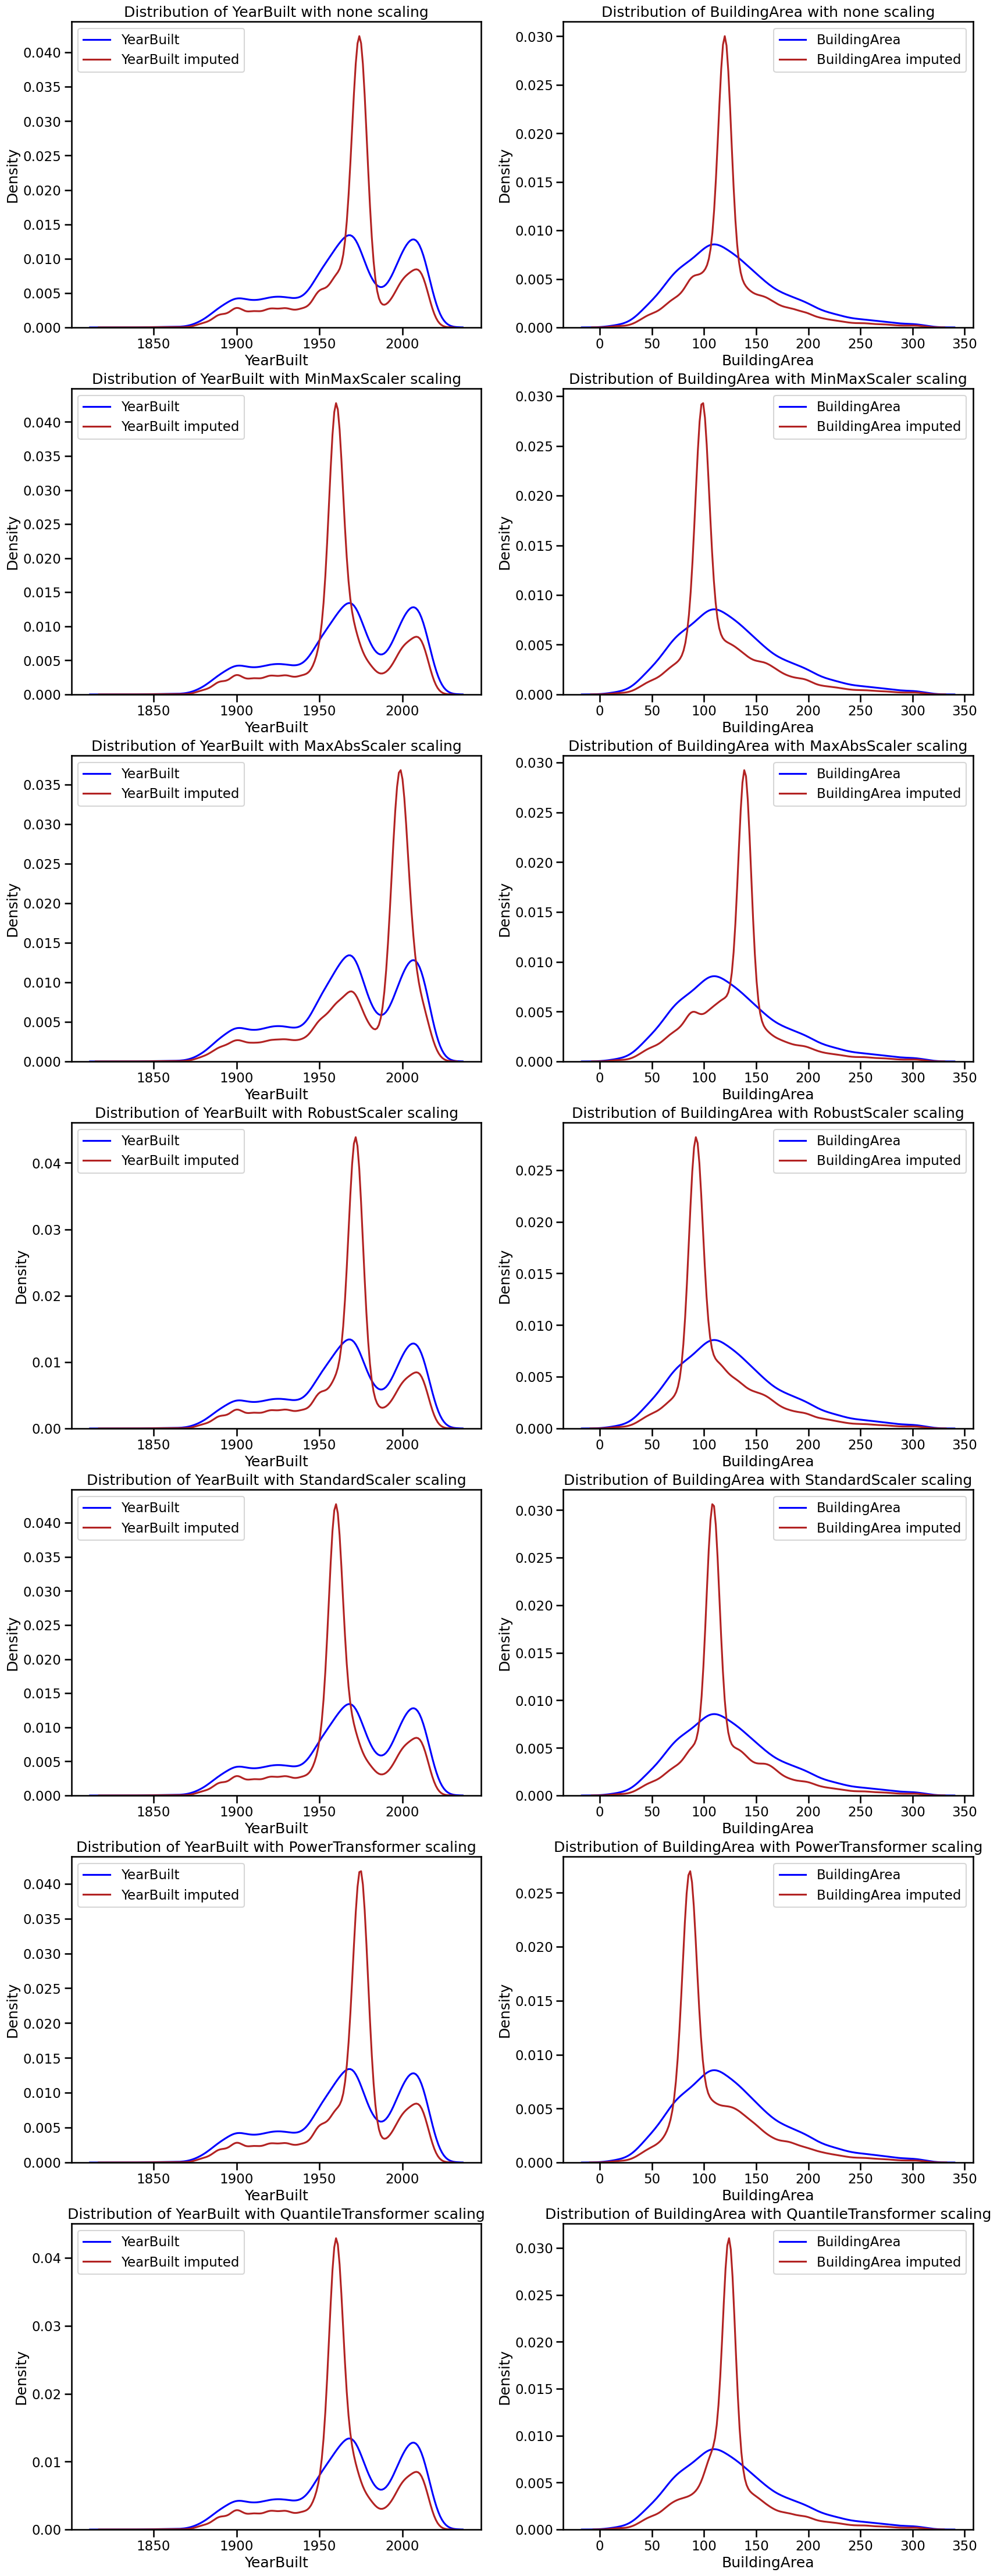

In [14]:
wrn.filterwarnings(action='ignore', category=RuntimeWarning)

# Possible scaling methods
scaler_list = [None, MinMaxScaler(), MaxAbsScaler(), RobustScaler(), StandardScaler(), PowerTransformer(), QuantileTransformer()]
imputed_data = []

fig, ax = plt.subplots(len(scaler_list), 2, figsize=(20, 8 * len(scaler_list)))

for i, scaler in enumerate(scaler_list):
    melb_scaling_knn_df = melb_df_knn.copy()

    # Scale the data
    if scaler: melb_scaling_knn_df = pd.DataFrame(scaler.fit_transform(melb_scaling_knn_df), columns=melb_scaling_knn_df.columns)

    # Impute the missing values
    mice_imputer = IterativeImputer(estimator=KNeighborsRegressor(), random_state=0)
    melb_scaling_knn_df[add_cols] = mice_imputer.fit_transform(melb_scaling_knn_df[add_cols])

    # Inverse the scaling
    if scaler: melb_scaling_knn_df = pd.DataFrame(scaler.inverse_transform(melb_scaling_knn_df), columns=melb_scaling_knn_df.columns)

    # Save the imputed data
    imputed_data.append(melb_scaling_knn_df)

    # GRAPH: KDE of the original vs. imputed data
    for j, col in enumerate(add_cols):
        print(f'    Plotting {col} with {scaler.__class__.__name__ if scaler else "none"} scaling in axis {i, j}...')
        kde_plot_2(melb_df_knn[col], melb_scaling_knn_df[col], col, col + ' imputed', \
                   f'Distribution of {col} with {scaler.__class__.__name__ if scaler else "none"} scaling', col, ax[i, j])
    
plt.show()

Por ello, entonces, si queremos ver todos los métodos juntos para ver cuál es el mejor para cada caso, vamos a dibujar todos los gráficos sobre la misma figura. Por ello, vamos a usar una función que dibuje más de dos gráficos en la misma figura.

In [15]:
def kde_plot_general(data, name, title, xlabel, ax):
    assert len(data) == len(name), 'The data, name and color lists must have the same length.'

    for d, n in zip(data, name):
        sns.kdeplot(d, fill=False, label=n, ax=ax, palette='hls')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel); ax.set_ylabel('Density')

    ax.legend()
    return

Con esta, vemos lo siguiente:

    Plotting YearBuilt with all the scalings in axis 0...
    Plotting BuildingArea with all the scalings in axis 1...


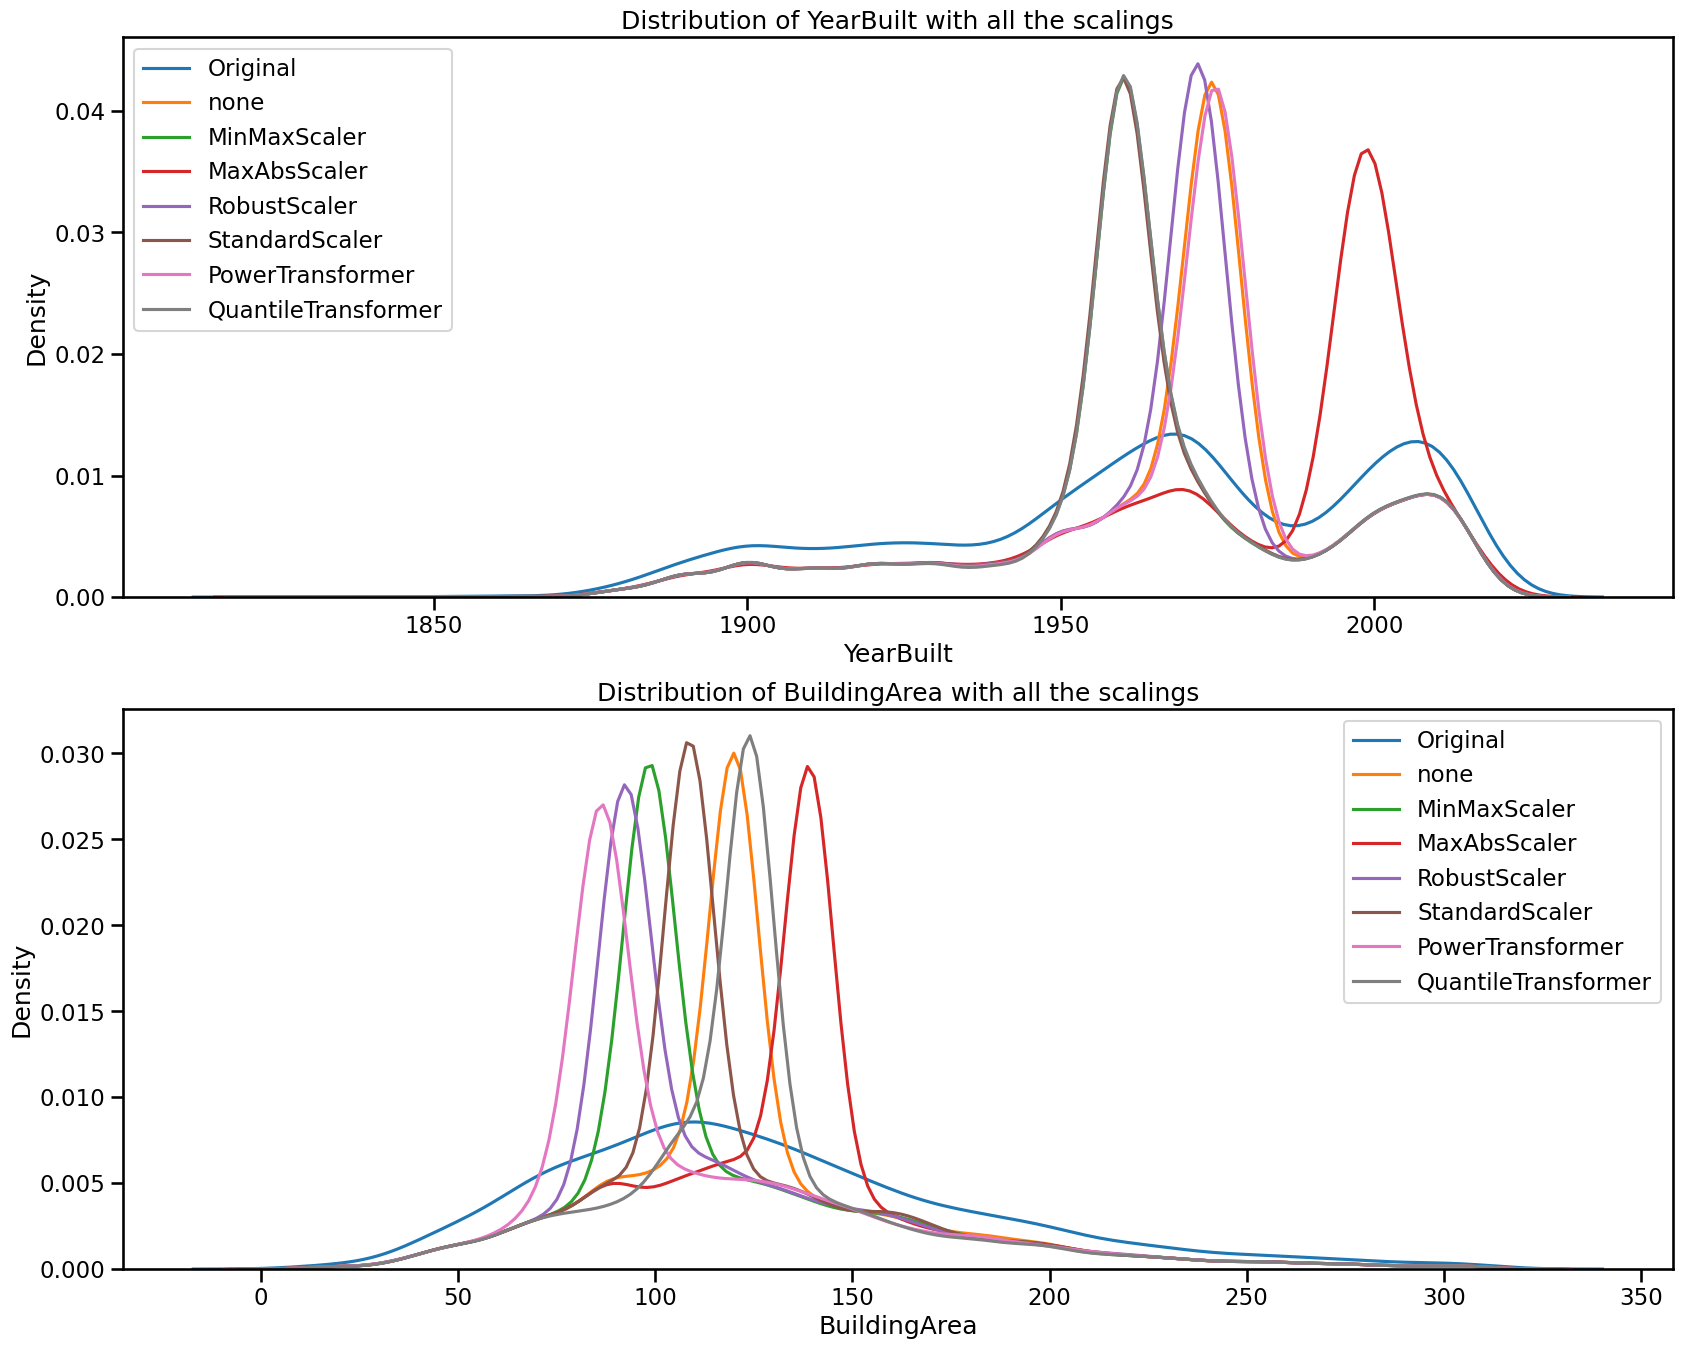

In [16]:
# GRAPH: KDE of the original vs. imputed data
fig, ax = plt.subplots(2, 1, figsize=(20, 16))

for i, col in enumerate(add_cols):
    print(f'    Plotting {col} with all the scalings in axis {i}...')
    kde_plot_general([melb_df_knn[col]] + [x[col] for x in imputed_data], \
                     ['Original'] + [(scaler.__class__.__name__ if scaler else 'none') for scaler in scaler_list], \
                        f'Distribution of {col} with all the scalings', col, ax[i])

plt.show()

Visto esto, entonces, vamos a elegir para:
- `YearBuilt`:
  - Imputación por KNN con *normalización* usando *QuantileTransformer*.
- `BuildingArea`:
  - Imputación por KNN con *scaling* usando *StandardScaler*.

Luego, hacemos los cambios correspondientes y graficamos para ver cómo quedaron las distribuciones finales comparadas con las iniciales.

In [17]:
# The chosen scalers
scaler_chosen = [0, 6]
print(f'The chosen scalers are: {[scaler_list[i].__class__.__name__ if i else "none" for i in scaler_chosen]}')

# Get the new DataFrame with the imputed values
melb_df_knn_final = melb_df_knn.copy()
for i in range(len(add_cols)):
    melb_df_knn_final[add_cols[i]] = imputed_data[scaler_chosen[i]][add_cols[i]]

# Show random 5 rows of the original vs. encoded DataFrame
display(melb_df_knn.sample(5, random_state=0))
display(melb_df_knn_final.sample(5, random_state=0))

# Check that there are no missing values
print(f'Number of missing values in the final DataFrame: {melb_df_knn_final.isna().sum().sum()}')

The chosen scalers are: ['none', 'QuantileTransformer']


,YearBuilt,BuildingArea,Price,Bedroom2,Rooms,Car,Landsize,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Eastern Victoria,Regionname=Northern Metropolitan,Regionname=Northern Victoria,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Western Metropolitan,Regionname=Western Victoria
7811,NaN,NaN,1116000.0,3.0,3.0,2.0,610.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1569,NaN,NaN,1012000.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4087,1995.0,287.0,1350000.0,4.0,4.0,2.0,646.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5252,1980.0,46.0,1080000.0,3.0,3.0,2.0,211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2804,NaN,NaN,485000.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,YearBuilt,BuildingArea,Price,Bedroom2,Rooms,Car,Landsize,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Eastern Victoria,Regionname=Northern Metropolitan,Regionname=Northern Victoria,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Western Metropolitan,Regionname=Western Victoria
7811,1974.4,124.0,1116000.0,3.0,3.0,2.0,610.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1569,1974.4,124.0,1012000.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4087,1995.0,287.0,1350000.0,4.0,4.0,2.0,646.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5252,1980.0,46.0,1080000.0,3.0,3.0,2.0,211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2804,1974.4,124.0,485000.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Number of missing values in the final DataFrame: 0


Ahora, si los graficamos, tenemos:

    Plotting YearBuilt with the chosen scalers in axis 0...
    Plotting BuildingArea with the chosen scalers in axis 1...


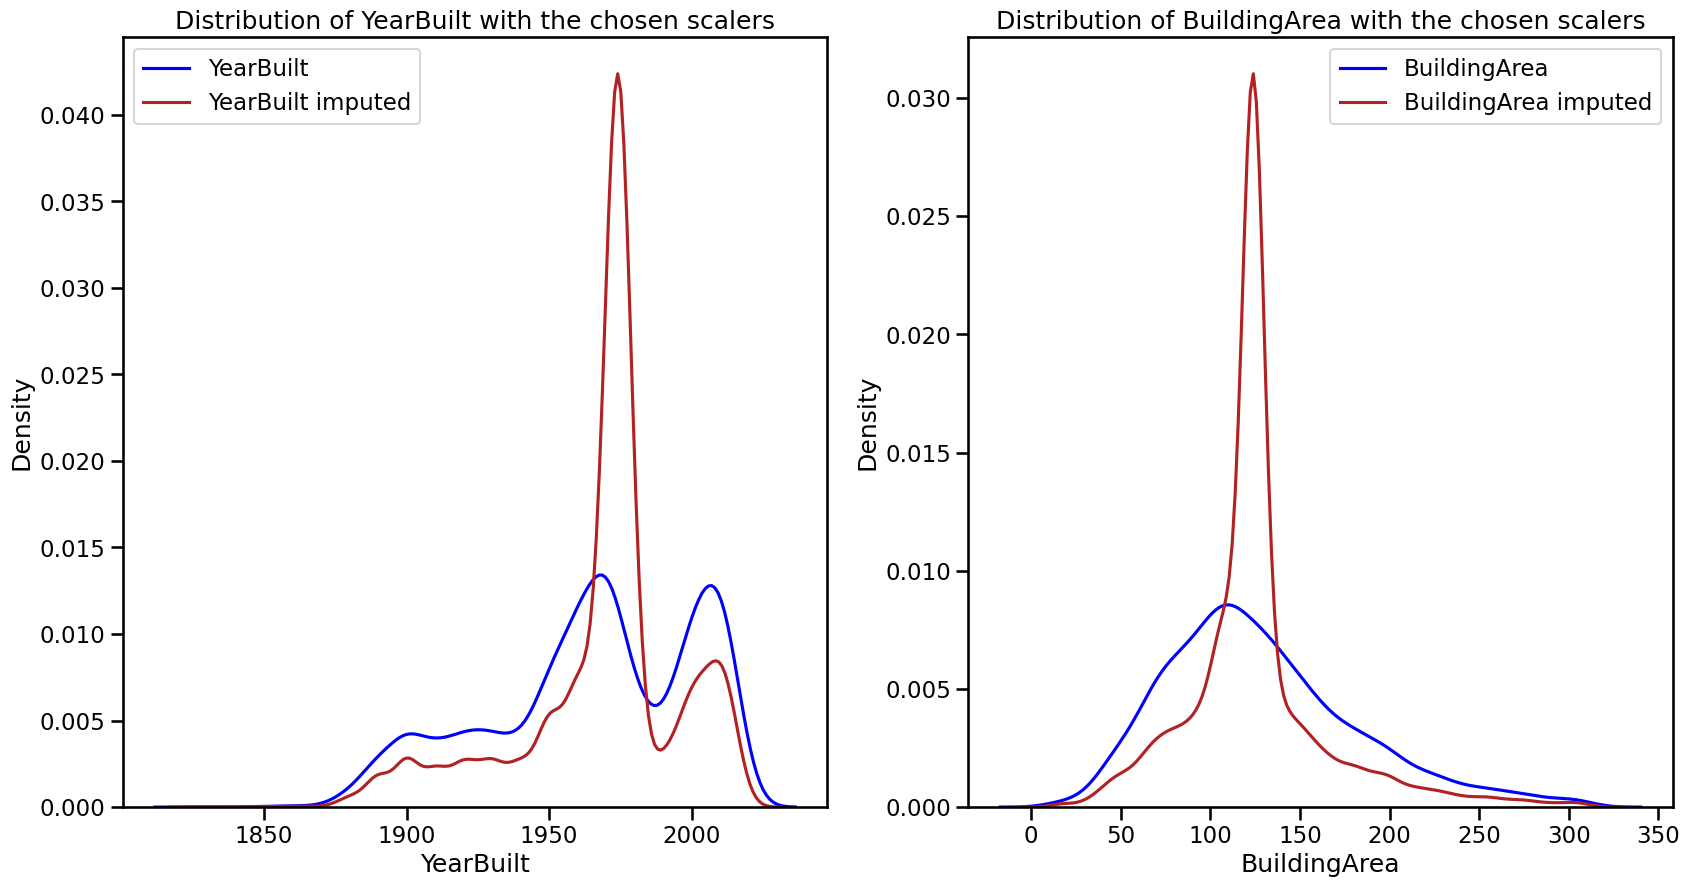

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for i, col in enumerate(add_cols):
    print(f'    Plotting {col} with the chosen scalers in axis {i}...')
    kde_plot_2(melb_df_knn[col], melb_df_knn_final[col], col, col + ' imputed', \
               f'Distribution of {col} with the chosen scalers', col, ax[i])

### Ejercicio 3: Reducción de dimensionalidad.

#### Consigna

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Seleccione las primeras $2$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

#### Resolución

El proceso de resolución de este ejercicio será similar al realizado para la imputación por KNN dado que probaremos los mismos *scalings* y *normalizaciones* para ver cuál es el mejor para este caso. Para ver con cuál necesitamos menos componentes para capturar las componentes principales y de mayor varianza respecto al resto.

Por ello mismo, veamos lo siguiente:

Calculating PCA with none scaling...
    Explained variance: [9.99999479e-01 5.12570967e-07 5.32670175e-09 2.95565547e-09
 3.91839657e-12 1.67233849e-12 1.25029516e-12 9.93503207e-13
 6.36915926e-13 5.06381695e-13 4.49967535e-13 1.53958891e-13
 1.48385938e-13 1.89593460e-14 1.19858337e-14 1.01474176e-14
 9.71749005e-42 8.32929956e-44]
    Plotting...
Calculating PCA with MinMaxScaler scaling...
    Explained variance: [9.99999479e-01 5.12570967e-07 5.32670175e-09 2.95565547e-09
 3.91839657e-12 1.67233849e-12 1.25029516e-12 9.93503207e-13
 6.36915926e-13 5.06381695e-13 4.49967535e-13 1.53958891e-13
 1.48385938e-13 1.89593460e-14 1.19858337e-14 1.01474176e-14
 9.71749005e-42 8.32929956e-44]
    Plotting...
Calculating PCA with MaxAbsScaler scaling...
    Explained variance: [9.99999479e-01 5.12570967e-07 5.32670175e-09 2.95565547e-09
 3.91839657e-12 1.67233849e-12 1.25029516e-12 9.93503207e-13
 6.36915926e-13 5.06381695e-13 4.49967535e-13 1.53958891e-13
 1.48385938e-13 1.89593460e-14 1.1

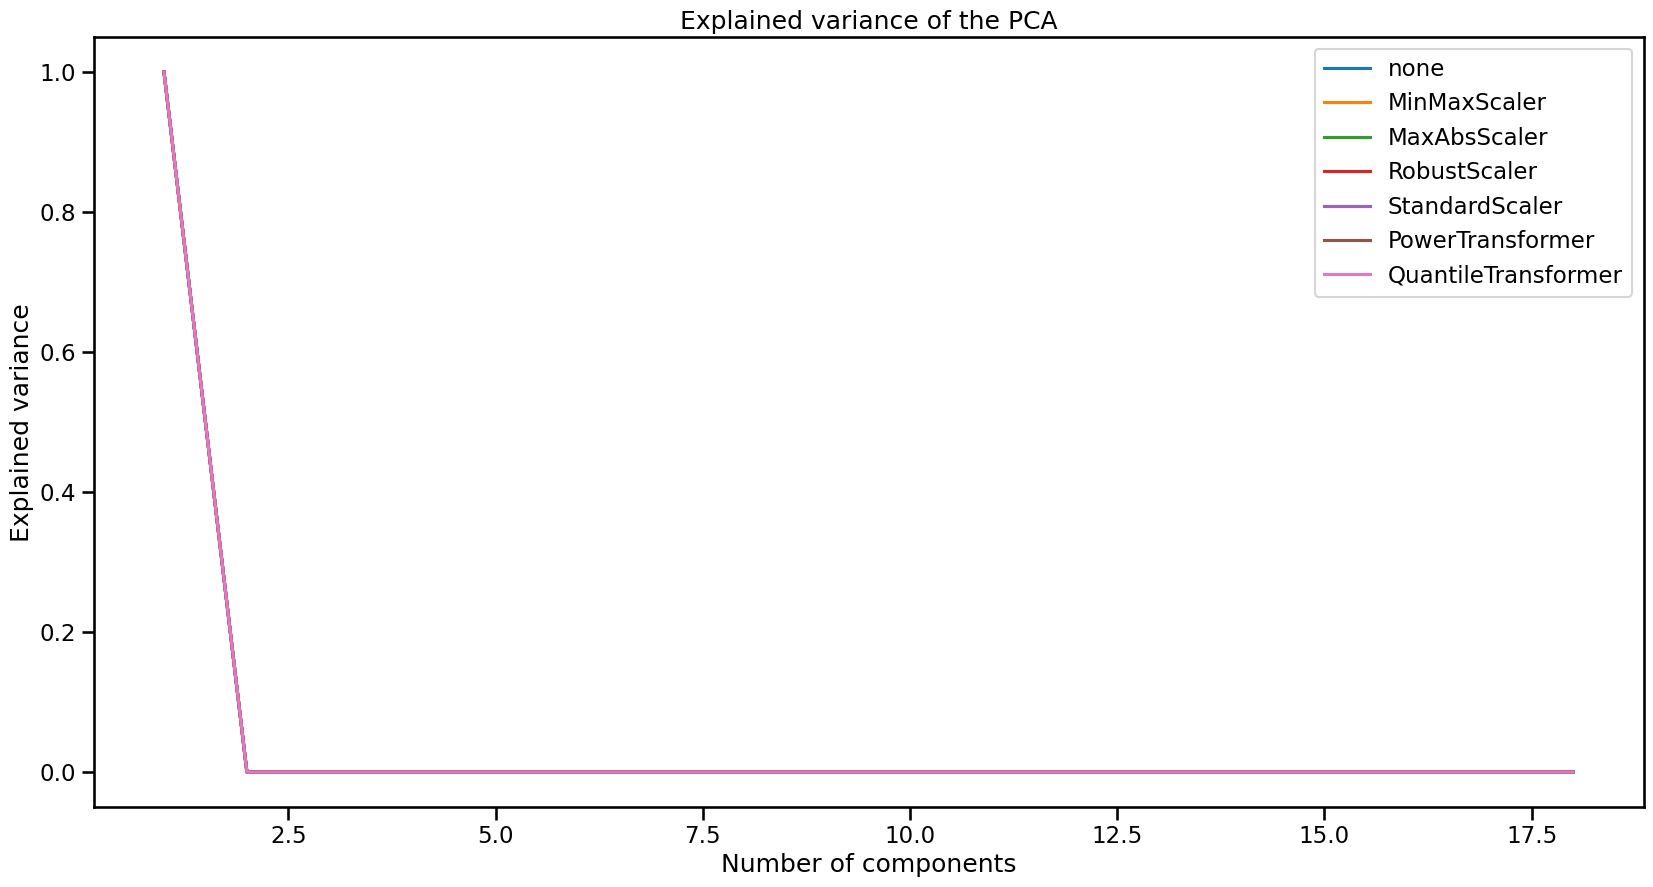

In [47]:
# Calculate the PCA data for each scaler and graph the explained variance
scaler_list = [None, MinMaxScaler(), MaxAbsScaler(), RobustScaler(), StandardScaler(), PowerTransformer(), QuantileTransformer()]
pca_list = []
pca_data_list = []

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for i, scaler in enumerate(scaler_list):
    print(f'Calculating PCA with {scaler.__class__.__name__ if scaler else "none"} scaling...')

    melb_df_pca = melb_df_knn_final.copy()

    n = min(20, len(melb_df_pca.columns))
    pca = PCA(n)
    melb_df_pca = pca.fit_transform(melb_df_knn_final)

    print(f'    Explained variance: {pca.explained_variance_ratio_}')

    pca_list.append(pca)
    pca_data_list.append(melb_df_pca)

    print(f'    Plotting...')
    sns.lineplot(x=range(1, n + 1), y=pca.explained_variance_ratio_, label=scaler.__class__.__name__ if scaler else 'none', ax=ax)

ax.set_title('Explained variance of the PCA')
ax.set_xlabel('Number of components')
ax.set_ylabel('Explained variance')

plt.show()


Por ello mismo, resulta muy interesante notar que en todos los casos nos da lo mismo, por lo que vamos a elegir no realizar ninguna transformación a los datos y quedarnos con las primeras dos componentes principales luego de realizar el PCA directamente con los datos imputados por KNN.

Algo a notar también es que con $2$ componentes ya capturamos casi toda la varianza de los datos, por lo que no es necesario quedarnos con más.

,YearBuilt,BuildingArea,Price,Bedroom2,Rooms,Car,Landsize,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Eastern Victoria,Regionname=Northern Metropolitan,Regionname=Northern Victoria,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Western Metropolitan,Regionname=Western Victoria,pca1,pca2
7811,1974.4,124.0,1116000.0,3.0,3.0,2.0,610.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,128883.874413,178.620070
1569,1974.4,124.0,1012000.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24883.789400,-416.596921
4087,1995.0,287.0,1350000.0,4.0,4.0,2.0,646.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,362883.882261,183.745260
5252,1980.0,46.0,1080000.0,3.0,3.0,2.0,211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,92883.815667,-216.282815
2804,1974.4,124.0,485000.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-502116.204951,-341.976507


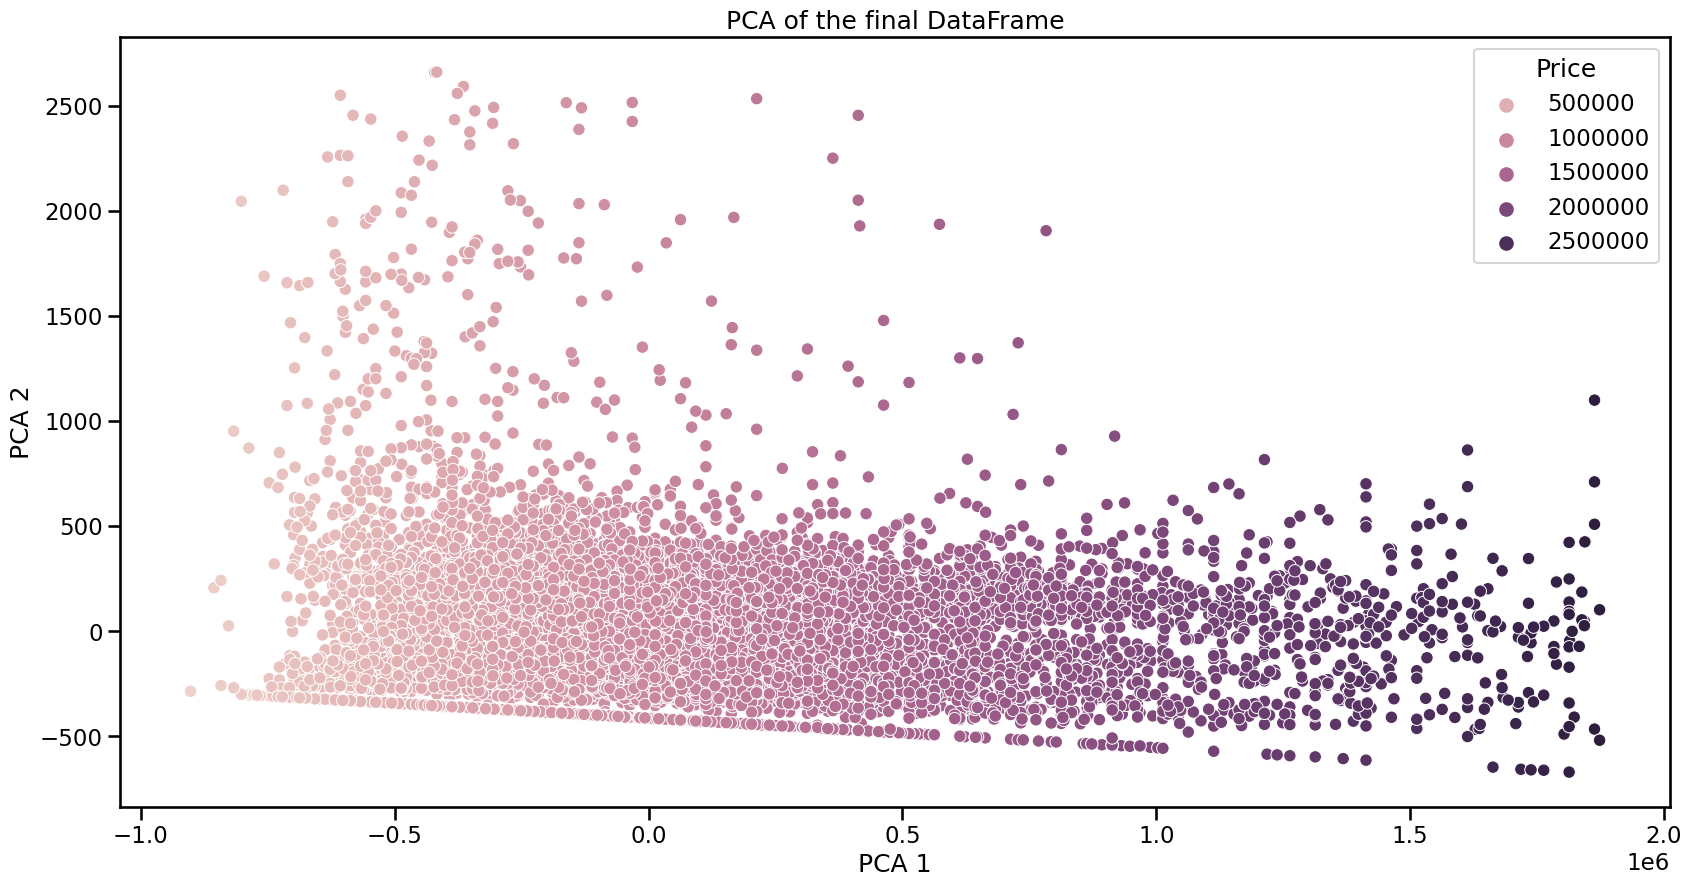

In [71]:
# Scaler chosen (None)
scaler_chosen = 0

# Copy and create the final DataFrame for PCA
melb_df_pca = melb_df_knn_final.copy()
melb_df_pca[['pca1', 'pca2']] = pca_data_list[scaler_chosen][:, :2]

# Show random 5 rows of the final DataFrame
display(melb_df_pca.sample(5, random_state=0))

# GRAPH: PCA of the final DataFrame
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.scatterplot(x='pca1', y='pca2', data=melb_df_pca, hue='Price', ax=ax)

ax.set_title('PCA of the final DataFrame')
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2')

plt.show()

### Ejercicio 4: Composición del resultado

#### Consigna

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

#### Resolución

Si bien ya tenemos el DataFrame resultado en *melb_df_pca*, vamos a realizar aquí, en este ejercicio, todas las transformaciones que se hicieron para que se encuentren de forma compacta y clara a la hora de ver la documentación. Anteriormente hicimos análisis de qué opción era mejor considerar, pero en este punto haremos directamente las transformaciones e imputaciones de datos.

,YearBuilt,BuildingArea,Price,Bedroom2,Rooms,Car,Landsize,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Eastern Victoria,Regionname=Northern Metropolitan,Regionname=Northern Victoria,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Western Metropolitan,Regionname=Western Victoria,pca1,pca2
7811,1960.0,108.6,1116000.0,3.0,3.0,2.0,610.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,128883.874232,178.509805
1569,1960.0,108.6,1012000.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24883.789220,-416.734071
4087,1995.0,287.0,1350000.0,4.0,4.0,2.0,646.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,362883.882299,183.380530
5252,1980.0,46.0,1080000.0,3.0,3.0,2.0,211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,92883.815755,-216.035142
2804,1960.0,108.6,485000.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-502116.205125,-342.142773


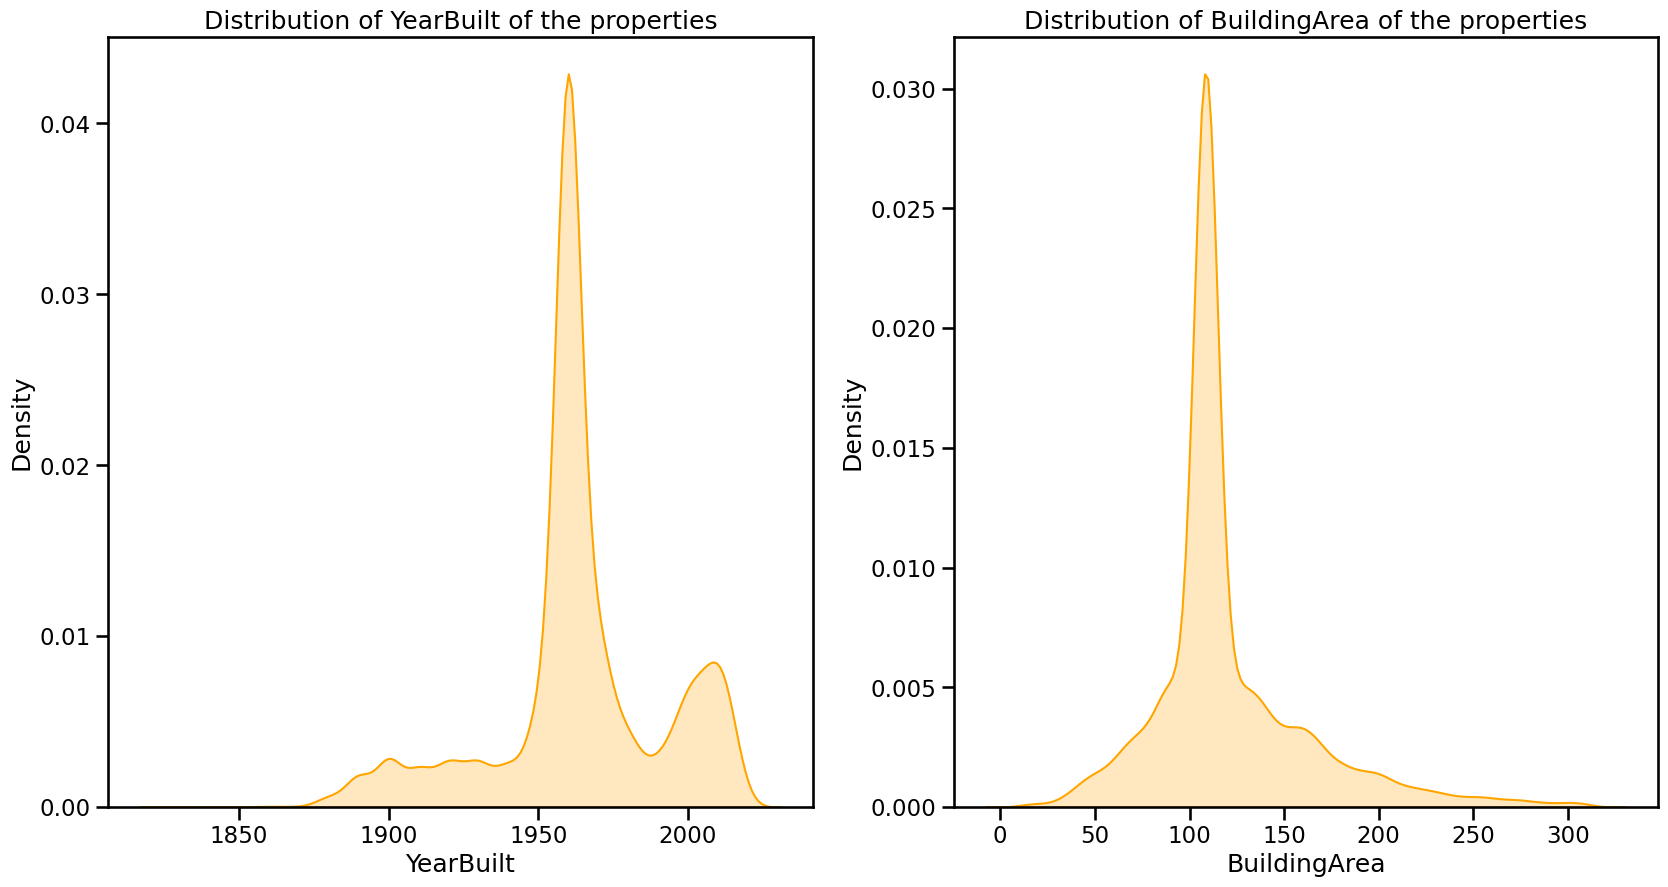

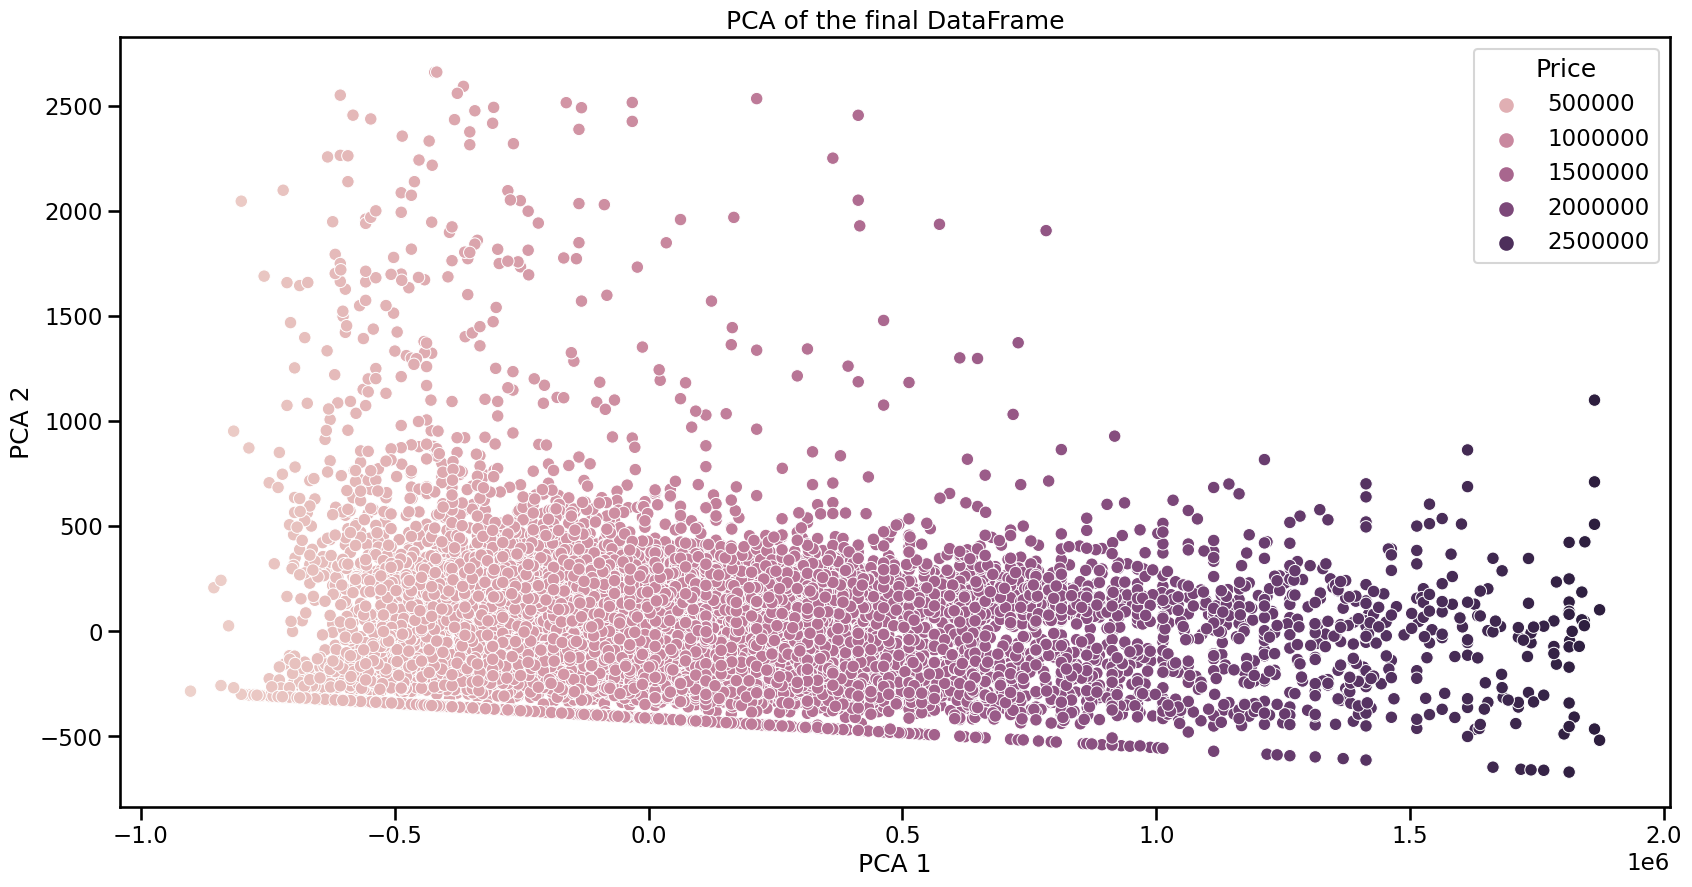

In [87]:
# Copy the original DataFrame (without the outliers)
melb_df_final = melb_df_orig.copy()

# SELECT THE COLUMNS TO USE
interesting_columns = ['Price', 'Bedroom2', 'Type', 'Rooms', 'Car', 'Landsize', 'Regionname', 'BuildingArea', 'YearBuilt']
melb_df_final = melb_df_final[interesting_columns]

# FILTER OUTLIERS
## Filtering
q_info = { 'Price': 0.98, 'Bedroom2': 0.99, 'Car': 0.99, 'Landsize': 0.99, 'BuildingArea': 0.98 }
for col, q in q_info.items():
    max_value = melb_df_final[col].quantile(q)
    melb_df_final = melb_df_final[(melb_df_final[col] < max_value) | (melb_df_final[col].isna())]

melb_df_final = melb_df_final[((melb_df_final['BuildingArea'] > 10) | (melb_df_final['BuildingArea'].isna()))]

## Reset the index
melb_df_final.reset_index(drop=True, inplace=True)

# ENCODING CATEGORICAL DATA
## One Hot Encoding
cat_cols = ['Type', 'Regionname']
OneHot = OneHotEncoder(handle_unknown='ignore', sparse_output=False, feature_name_combiner=lambda f, c: f + '=' + c)
nw_cat_cols = OneHot.fit_transform(melb_df[cat_cols])
nw_cat_names = OneHot.get_feature_names_out(cat_cols)

## Add the numerical columns to the new data
num_cols = ['Price', 'Bedroom2', 'Rooms', 'Car', 'Landsize']
nw_cols = np.hstack([melb_df[num_cols].values, nw_cat_cols])
nw_names = num_cols + nw_cat_names.tolist()

## Convert to DataFrame
melb_df_final = pd.DataFrame(nw_cols, columns=nw_names)

# KNN IMPUTATION
## Add YearBuilt and BuildingArea columns
add_cols = ['YearBuilt', 'BuildingArea']
melb_df_final = pd.concat([melb_df[add_cols], melb_df_final], axis=1)

## Scale the data
### YearBuilt case
quantile_scaler = QuantileTransformer(random_state=0)
quantile_scaling = pd.DataFrame(quantile_scaler.fit_transform(melb_df_final), columns=melb_df_final.columns)

### BuildingArea case
standard_scaler = StandardScaler()
standard_scaling = pd.DataFrame(standard_scaler.fit_transform(melb_df_final), columns=melb_df_final.columns)

## Impute the missing values
### YearBuilt case
mice_imputer = IterativeImputer(estimator=KNeighborsRegressor(), random_state=0)
quantile_scaling[add_cols] = mice_imputer.fit_transform(quantile_scaling[add_cols])

### BuildingArea case
mice_imputer = IterativeImputer(estimator=KNeighborsRegressor(), random_state=0)
standard_scaling[add_cols] = mice_imputer.fit_transform(standard_scaling[add_cols])

## Inverse the scaling
### YearBuilt case
quantile_scaling = pd.DataFrame(quantile_scaler.inverse_transform(quantile_scaling), columns=quantile_scaling.columns)

### BuildingArea case
standard_scaling = pd.DataFrame(standard_scaler.inverse_transform(standard_scaling), columns=standard_scaling.columns)

## Merge the imputed data
melb_df_final['YearBuilt'] = quantile_scaling['YearBuilt']
melb_df_final['BuildingArea'] = standard_scaling['BuildingArea']

## Check that there are no missing values
assert melb_df_final.isna().sum().sum() == 0, 'There are missing values in the final DataFrame.'

# Dimensionality reduction (PCA)
pca = PCA(min(20, len(melb_df_final.columns)))
melb_df_final[['pca1', 'pca2']] = pca.fit_transform(melb_df_final)[:, :2]

# Save the results in a CSV file
melb_df_final.to_csv('melb_data_processed.csv', index=False)

# Print results
## Show random 5 rows of the final DataFrame
display(melb_df_final.sample(5, random_state=0))

## Show imputed data distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
kde_plot(melb_df_final, 'YearBuilt', 'Distribution of YearBuilt of the properties', 'YearBuilt', ax[0])
kde_plot(melb_df_final, 'BuildingArea', 'Distribution of BuildingArea of the properties', 'BuildingArea', ax[1])

## Scatter plot of the PCA
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.scatterplot(x='pca1', y='pca2', data=melb_df_final, hue='Price', ax=ax)
ax.set_title('PCA of the final DataFrame')
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2')
plt.show()

### Ejercicio 5: Documentación

#### Consigna

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso.

#### Resolución

La documentación se encuentra en el archivo `Reporte_Entregable_2.md`. Lo transcribo aquí dado que fue hecho con *Markdown*:

##### Criterios de exclusión de ejemplos

1. Se eliminan los ejemplos que tengan valores mayores al:
   - $98\%$ de los datos para `Price`.
   - $99\%$ de los datos para `Bedroom2`.
   - $99\%$ de los datos para `Car`.
   - $99\%$ de los datos para `Landsize`.
   - $98\%$ de los datos para `BuildingArea`.
2. Se eliminan los ejemplos que tengan valores menores a:
   - $10$ para `BuildingArea`.

##### Características seleccionadas

- *Categóricas* -> se codifican con *One-Hot* sin reducción de categorías:
  - `Type`: tipo de propiedad (h: casa, u: departamento, t: casa adosada).
  - `Regionname`: región de Melbourne.
- *Numéricas*
  - `Price`: precio de la propiedad.
  - `Bedroom2`: cantidad de dormitorios.
  - `Rooms`: cantidad de habitaciones.
  - `Car`: cantidad de cocheras.
  - `Landsize`: tamaño del terreno.
  - `YearBuilt`: año de construcción.
  - `BuildingArea`: tamaño de la construcción.

##### Transformaciones e imputaciones realizadas
- Se imputa `YearBuilt` con KNN realizando una *normalización* a los datos con *QuantileTransformer* (luego se invierte para obtener los datos originales).
- Se imputa `BuildingArea` con KNN realizando un *escalado* a los datos con *StandardScaler* (luego se invierte para obtener los datos originales).

##### Datos aumentados
- Se aumentan los datos con PCA para obtener las primeras dos componentes principales de los datos imputados por KNN.